## 混合ガウス分布で分布関数は近似できるか？

In [1]:
using LinearAlgebra, Plots

In [2]:
mutable struct gParams
    K::Int
    μ::Vector{Float32}
    Σ::Vector{Float32}
    ϕ::Vector{Float32}
end

function init_params(K::Int)
    μ = rand(Uniform(-1.0,1.0),K)
    Σ = ones(K)
    ϕ = [1.0/K for i in 1:K]
    return gParams(K, μ, Σ, ϕ)
end

init_params (generic function with 1 method)

In [3]:
using Distributions

In [4]:
function gmm0(w::Float32, p::gParams)
    μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([ϕ[i]*pdf(Normal(μ[i], Σ[i]), w) for i in 1:p.K])
    return y
end
function gmm1(w::Float32, p::gParams)
    #μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([p.ϕ[i]*pdf(Normal(p.μ[i], p.Σ[i]), w) for i in 1:p.K])
    return y
end

function logpws(ws::Vector{Float32}, true_ρ::Vector{Float32}, p::gParams)
    dw = ws[2]-ws[1]
    return dw*(true_ρ'*[log(gmm1(w, p)) for w in ws])
end

function D_kl(ws::Vector{Float32}, true_ρ::Vector{Float32}, p::gParams)
    f(x) = gmm1(x, p)
    K = length(ws)
    dw = ws[2]-ws[1]
    return sum([dw*true_ρ[i]*(log(true_ρ[i]+1f-8)-log(f(ws[i])+1f-8)) for i in 1:K])
end

function p_now(ws::Vector{Float32}, p::gParams)
    f(x) = gmm1(x, p)
    return Float32[f(w) for w in ws]
end

p_now (generic function with 1 method)

In [5]:
function E_step(ws::Vector{Float32}, p::gParams)
    q = zeros(Float32, size(ws)[1], p.K)
    for (i,w) in enumerate(ws)
        for k in 1:p.K
            q[i,k] = p.ϕ[k]*pdf(Normal(p.μ[k], p.Σ[k]), w)
        end
        q[i,:] = q[i,:]/(sum(q[i,:])+1f-8)
    end
    return q
end

function M_step!(ws::Vector{Float32}, true_ρ::Vector{Float32}, q::Matrix{Float32}, params::gParams)
    Nd = size(ws)[1]
    dw = ws[2] - ws[1]
    for k in 1:params.K
        qsum = true_ρ'*q[:,k]
        params.ϕ[k] = dw*qsum
        params.μ[k] = sum(true_ρ .* q[:,k] .* ws)/qsum
        #params.Σ[k] = sum(true_ρ .* q[:,k] .* (ws .- params.μ[k]) .* (ws .- params.μ[k]))/qsum
        params.Σ[k] = sqrt(sum([true_ρ[i] * q[i,k] * (ws[i] - params.μ[k]) * (ws[i] - params.μ[k]) for i in 1:Nd])/qsum)
        #params.Σ[k] = params.Σ[k]/qsum
    end
    params.ϕ = params.ϕ/sum(params.ϕ)
end

M_step! (generic function with 1 method)

In [7]:
using Flux

In [125]:
X = 5
@show μs = Float32.(rand(Uniform(-0.5f0,0.5f0),X))
@show σs = Float32.(rand(Uniform(0.01f0,0.2f0),X))
@show ρs = softmax(randn(Float32, X))


μs = Float32.(rand(Uniform(-0.5f0, 0.5f0), X)) = Float32[0.009273507, -0.06498715, -0.23630303, -0.16722716, 0.10089957]
σs = Float32.(rand(Uniform(0.01f0, 0.2f0), X)) = Float32[0.04147988, 0.07123151, 0.09267192, 0.015464015, 0.12846965]
ρs = softmax(randn(Float32, X)) = Float32[0.2398301, 0.22191928, 0.02175142, 0.36370423, 0.15279497]


5-element Vector{Float32}:
 0.2398301
 0.22191928
 0.02175142
 0.36370423
 0.15279497

In [8]:
ws = [range(-1.0f0,1.0f0, length=501)...]
#gg(x, η) = (2η/((x-0.1)^2+η^2))/(2pi)
gg(x, η) = (2η/((x-0.2)^2+η^2) + 2η/((x+0.2)^2+η^2))/(4pi)
true_ρ = Float32[gg(w, 0.02f0) for w in ws]
#true_ρ = [gmm0(w, gParams(X, μs, σs, ρs)) for w in ws]

501-element Vector{Float32}:
 0.007180357
 0.0072452077
 0.0073109674
 0.0073776534
 0.007445283
 0.0075138756
 0.007583449
 0.007654024
 0.0077256183
 0.0077982536
 0.00787195
 0.007946729
 0.00802261
 ⋮
 0.007946729
 0.00787195
 0.0077982536
 0.0077256183
 0.007654024
 0.007583449
 0.0075138756
 0.007445283
 0.0073776534
 0.0073109674
 0.0072452077
 0.007180357

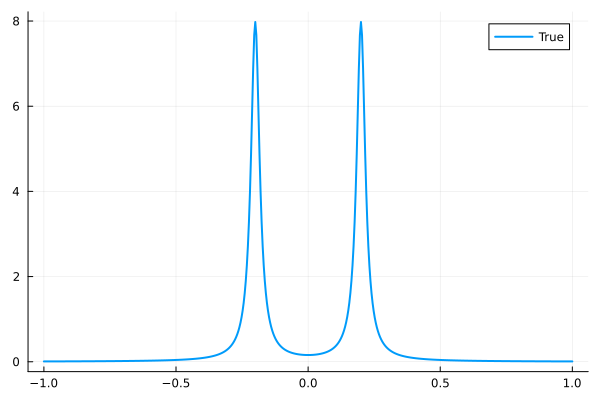

In [9]:
plot(ws, true_ρ, linewidth=2, label="True")

In [12]:
#plot(ws, true_ρ, linewidth=2, label="True")
function EM(dkl_max::Float32, X::Int)
    #X = 10
    itr_max = 2000
    th = 1e-6
    gp = init_params(X)
    old_logpx = logpws(ws, true_ρ, gp)

    for i in 1:itr_max
        qs = E_step(ws, gp)
        #println(qs)
        M_step!(ws, true_ρ, qs, gp)
        new_logpx = logpws(ws, true_ρ, gp)
        dkl = D_kl(ws, true_ρ, gp)
        if (abs(new_logpx - old_logpx) < th && dkl < dkl_max)
            #dkl = D_kl(ws, true_ρ, gp)
            println("itr: ", i, " logpx: ", new_logpx, " converged!")
            println("D_kl: ", dkl)
            break
        end
        old_logpx = new_logpx
    end
    return gp
end

EM (generic function with 2 methods)

itr: 361 logpx: 0.88662606 converged!
D_kl: -0.011735443


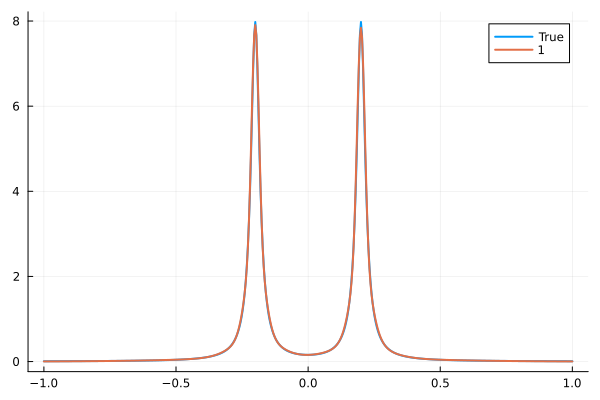

In [14]:
gp =  EM(0.01f0, 10)
p_test = p_now(ws, gp)
plot(ws, true_ρ, linewidth=2, label="True")
plot!(ws, p_test, linewidth=2, label="1")

itr: 191 logpx: 0.88443464 converged!
D_kl: -0.009544115


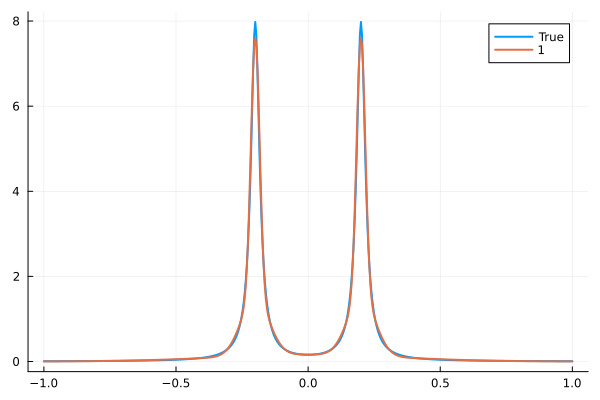

In [15]:
gp =  EM(0.001f0, 5)
p_test = p_now(ws, gp)
plot(ws, true_ρ, linewidth=2, label="True")
plot!(ws, p_test, linewidth=2, label="1")

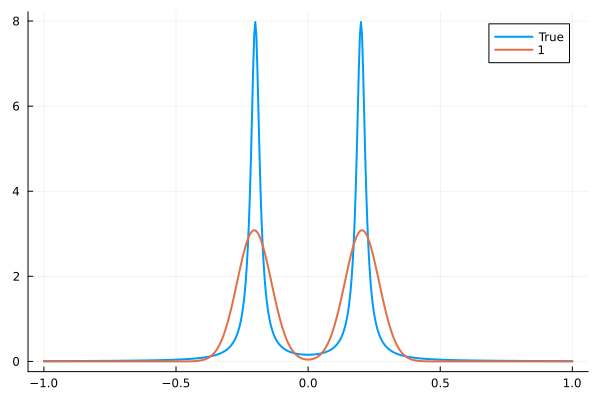

In [17]:
gp =  EM(0.1f0, 2)
p_test = p_now(ws, gp)
plot(ws, true_ρ, linewidth=2, label="True")
plot!(ws, p_test, linewidth=2, label="1")

## 近似した結果物理量とかは変わるのか？ (伝導度チェック)

In [18]:
struct H_params
    t::Float32
    μ::Float32
    β::Float32
    K_size::Int
    ws::Vector{Float32}
end

In [28]:
function Ham(k::Vector{Float32}, p::H_params)
    return -p.t * sum(cos.(k)) + p.μ
end

Ham (generic function with 1 method)

In [20]:
mutable struct Hamiltonian
    Hk::Float32
    Vx::Float32
    Vy::Float32
    #ws::Vector{Float32}
end

In [59]:
function HandV(k::Vector{Float32}, p::H_params)
    Hk = Ham(k, p)
    Vx = p.t * sin(k[1])
    Vy = p.t * sin(k[2])
    #ws = [range(-1.0f0,1.0f0, length=501)...]
    return Hamiltonian(Hk, Vx, Vy)
end

function ρwk(k::Vector{Float32}, w_e::Float32, η::Float32)
    return η/((w_e)^2+ η^2)/pi
end

function ρwk_vec(k::Vector{Float32}, ws::Vector{Float32}, e::Float32, η::Float32)
    return [ρwk(k, w-e, η) for w in ws]
end

function EM_fit(itr_max::Int, X::Int, ws::Vector{Float32}, ρ::Vector{Float32})
    th = 1e-6
    gp = init_params(X)
    old_logpx = logpws(ws, true_ρ, gp)

    for i in 1:itr_max
        qs = E_step(ws, gp)
        M_step!(ws, ρ, qs, gp)
        new_logpx = logpws(ws, ρ, gp)
        dkl = D_kl(ws, ρ, gp)
        if (abs(new_logpx - old_logpx) < th && dkl < 1f-3)
            break
        end
        old_logpx = new_logpx
    end

    dkl = D_kl(ws, ρ, gp)
    if(dkl > 0.1f0)
        println("D_KL: ", dkl)
    end
    p_app = p_now(ws, gp)

    return p_app
end

EM_fit (generic function with 1 method)

In [23]:
ph = H_params(0.2f0, 0.0f0, 100f0, 100, [range(-1.0f0,1.0f0, length=501)...])

H_params(0.2f0, 0.0f0, 100.0f0, 100, Float32[-1.0, -0.996, -0.992, -0.988, -0.984, -0.98, -0.976, -0.972, -0.968, -0.964  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0])

In [32]:
kxv = collect(Float32,-pi:2*pi/ph.K_size:pi)
kyv = collect(Float32,-pi:2*pi/ph.K_size:pi)
dk = 0.01f0
#Float32((kxv[2] - kxv[1])/2pi)

0.01f0

In [62]:
function fd(β::Float32, w::Float32)
    return Float32(1/(exp(β*w) + 1))
end
function dfd(β::Float32, w::Float32)
    return Float32(1/(exp(β*w) + 1)/(exp(-β*w) + 1))
end
function fds(β::Float32, ws::Vector{Float32})
    return [fd(β, w) for w in ws]
end
function dfds(β::Float32, ws::Vector{Float32})
    return [dfd(β, w) for w in ws]
end

dfds (generic function with 1 method)

In [65]:
function check_xx(μ::Float32, β::Float32)
    ph = H_params(0.2f0, μ, β, 100, [range(-1.0f0,1.0f0, length=501)...])
    σxx_true = 0.0f0
    σxx_gmm = 0.0f0
    dfdv = dfds(ph.β, ph.ws)
    #=
    kx = Float32(pi/2)
    ky = Float32(pi/2)
    Hs = HandV([kx, ky], ph)
    ρw = ρwk_vec([kx, ky], ws, Hs.Hk, 0.02f0)
    σxx_true = dk^2*Hs.Vx^2*sum(ρw.^2 .* fdv)
    ρ_gmm = EM_fit(3000, 5, ph.ws, ρw)
    σxx_gmm = dk^2*Hs.Vx^2*sum(ρ_gmm.^2 .* fdv)=#
    
    for kx in kxv
        for ky in kyv
            Hs = HandV([kx, ky], ph)
            ρw = ρwk_vec([kx, ky], ws, Hs.Hk, 0.02f0)
            σxx_true += dk^2*Hs.Vx^2*sum(ρw.^2 .* dfdv)
            ρ_gmm = EM_fit(2000, 10, ph.ws, ρw)
            σxx_gmm += dk^2*Hs.Vx^2*sum(ρ_gmm.^2 .* dfdv)
        end
    end
    dkl = ρw'*[log(ρw[i]+1f-8)-log(ρ_gmm[i]+1f-8) for i in 1:length(ρw)]
    dkl *= (ph.ws[2] - ph.ws[1])

    return σxx_true, σxx_gmm, dkl
end
#println("True: ", σxx_true)
#println("GMM: ", σxx_gmm)
#println("dkl: ", ρw'*[log(ρw[i]+1f-8)-log(ρ_gmm[i]+1f-8) for i in 1:length(ρw)])

check_xx (generic function with 1 method)

In [66]:
true_mu = Float32[]
gmm_mu = Float32[]
dkl_mu = Float32[]

μs = collect(Float32, -0.5:0.1:0.4)
for μ in μs
    xx_true, xx_gmm, dkl = check_xx(μ, 100f0)
    push!(true_mu, xx_true)
    push!(gmm_mu, xx_gmm)
    push!(dkl_mu, dkl)
end

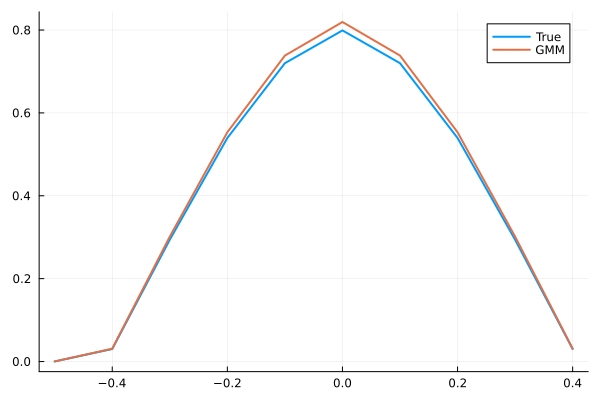

In [67]:
plot(μs, true_mu, linewidth=2, label="True")
plot!(μs, gmm_mu, linewidth=2, label="GMM")

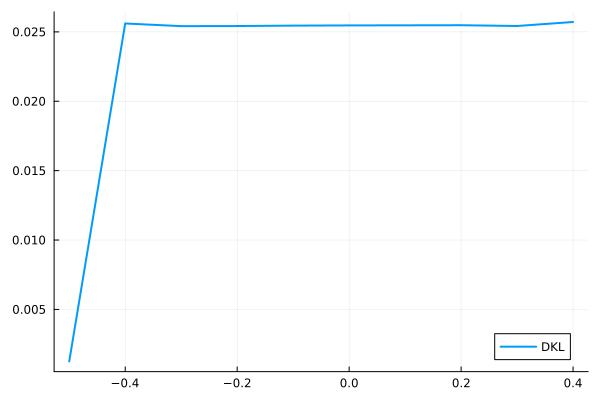

In [70]:
dels = (gmm_mu - true_mu)
plot(μs, dels./true_mu , linewidth=2, label="DKL")

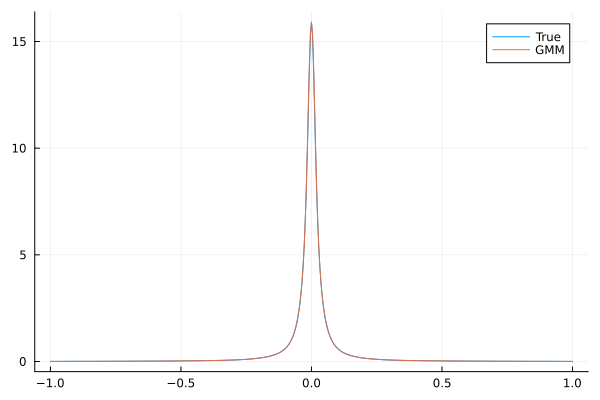

In [44]:
plot(ws, ρw, linewidth=1, label="True")
plot!(ws, ρ_gmm, linewidth=1, label="GMM")